## Pipeline

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fauzantaufik/boston-housepredict")

print("Path to dataset files:", path)

c:\ProgramData\anaconda3\envs\mi_ambiente\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\ProgramData\anaconda3\envs\mi_ambiente\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 13.3k/13.3k [00:00<00:00, 27.3MB/s]

Extracting model files...
Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\fauzantaufik\boston-housepredict\versions\1


Mean Squared Error (MSE): 24.29
R² Score: 0.669


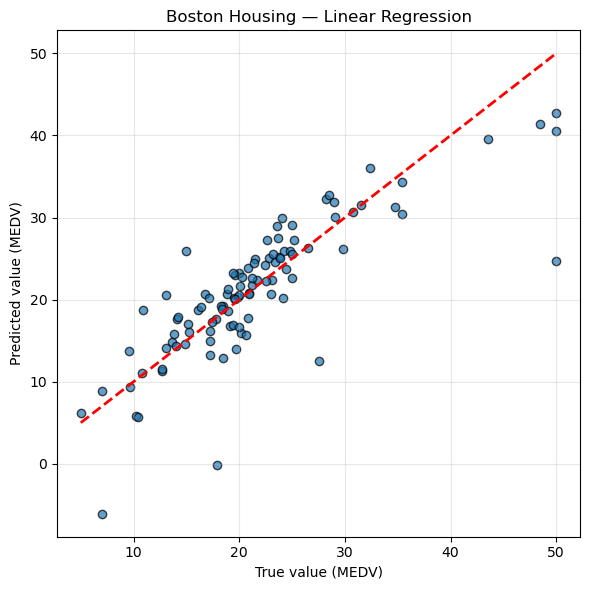

CV RMSE: mean=4.793, std=0.626
CV R^2 : mean=0.717, std=0.075


Hold-out Accuracy : 0.804
Hold-out Precision: 0.793
Hold-out Recall   : 0.667
Hold-out F1-score : 0.724


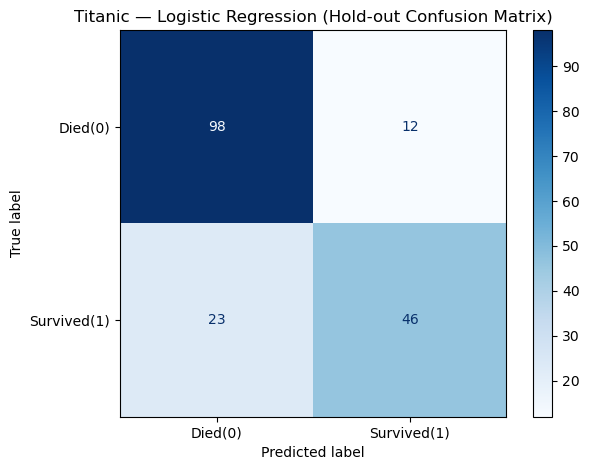


5-fold cross-validation:
CV Accuracy : 0.801 ± 0.025
CV Precision: 0.765 ± 0.047
CV Recall   : 0.695 ± 0.051
CV F1-score : 0.727 ± 0.042

Top positive coefficients (push toward Survived=1):
       feature      coef
7   Sex_female  1.364351
4     Pclass_1  1.038653
10  Embarked_Q  0.348068
5     Pclass_2  0.138022
1         Fare  0.133851
9   Embarked_C  0.095733
3        Parch -0.070794
2        SibSp -0.261398
11  Embarked_S -0.321817
0          Age -0.489323

Top negative coefficients (push toward Survived=0):
       feature      coef
10  Embarked_Q  0.348068
5     Pclass_2  0.138022
1         Fare  0.133851
9   Embarked_C  0.095733
3        Parch -0.070794
2        SibSp -0.261398
11  Embarked_S -0.321817
0          Age -0.489323
6     Pclass_3 -1.054692
8     Sex_male -1.242368


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# set your local path to Kaggle's train.csv
TRAIN_CSV = r"C:\Users\Usuario\ML_Class\mlct\data\external\titanic\train.csv"  # <- change if needed
df = pd.read_csv(TRAIN_CSV)

# target is Survived (0/1)
y = df["Survived"].astype(int)

# drop ID-like and high-cardinality text fields that don't help directly
drop_cols = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"]
X = df.drop(columns=drop_cols, errors="ignore")

# if any is missing in your CSV (rare), ColumnTransformer will ignore via 'remainder'
numeric_features = ["Age", "Fare", "SibSp", "Parch"]
categorical_features = ["Pclass", "Sex", "Embarked"]


# numeric: impute missing with median, then scale
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical: impute missing with most frequent, then one-hot encode
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# column-wise preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop"  # drop any column not listed above
)

# you can add class_weight='balanced' if you want to compensate class imbalance
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])


# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# train and evaluate on hold-out test
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Hold-out Accuracy : {acc:.3f}")
print(f"Hold-out Precision: {prec:.3f}")
print(f"Hold-out Recall   : {rec:.3f}")
print(f"Hold-out F1-score : {f1:.3f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Died(0)", "Survived(1)"]).plot(cmap="Blues")
plt.title("Titanic — Logistic Regression (Hold-out Confusion Matrix)")
plt.tight_layout()
plt.show()


# k-fold cross-validation (optional but recommended)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipe, X, y, cv=cv, n_jobs=-1,
    scoring=["accuracy", "precision", "recall", "f1"]
)

print("\n5-fold cross-validation:")
print(f"CV Accuracy : {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
print(f"CV Precision: {scores['test_precision'].mean():.3f} ± {scores['test_precision'].std():.3f}")
print(f"CV Recall   : {scores['test_recall'].mean():.3f} ± {scores['test_recall'].std():.3f}")
print(f"CV F1-score : {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}")


# optional: show top coefficients (interpretable weights)

# extract feature names after preprocessing for interpretation
feature_names_num = numeric_features
feature_names_cat = pipe.named_steps["preprocess"]\
                        .named_transformers_["cat"]\
                        .named_steps["onehot"]\
                        .get_feature_names_out(categorical_features).tolist()
feature_names = feature_names_num + feature_names_cat

# get model coefficients from the fitted pipeline
clf = pipe.named_steps["clf"]
coefs = clf.coef_.ravel()

# build a dataframe of coefficients
coef_df = pd.DataFrame(
    {"feature": feature_names, "coef": coefs}
).sort_values("coef", ascending=False)

print("\nTop positive coefficients (push toward Survived=1):")
print(coef_df.head(10))
print("\nTop negative coefficients (push toward Survived=0):")
print(coef_df.tail(10))
